In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,KFold, cross_val_score,cross_validate,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from time import time
import joblib

## Data Import & Exploration

In [2]:
# Switching to the source directory

project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
project_root
print(project_root)

C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_estimator


In [3]:
# Define datasource path

data_source = 'data'
file_name = 'premiums_rest'
file_extension = 'xlsx'

datasource_path = fr'{project_root}\{data_source}\{file_name}.{file_extension}'
datasource_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator\\data\\premiums_rest.xlsx'

In [4]:
# Reading the data

df = pd.read_excel(datasource_path,sheet_name='v1')

In [5]:
# Displaying the data

df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [6]:
df.shape

(29904, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    29904 non-null  int64 
 1   Gender                 29904 non-null  object
 2   Region                 29904 non-null  object
 3   Marital_status         29904 non-null  object
 4   Number Of Dependants   29904 non-null  int64 
 5   BMI_Category           29904 non-null  object
 6   Smoking_Status         29895 non-null  object
 7   Employment_Status      29903 non-null  object
 8   Income_Level           29895 non-null  object
 9   Income_Lakhs           29904 non-null  int64 
 10  Medical History        29904 non-null  object
 11  Insurance_Plan         29904 non-null  object
 12  Annual_Premium_Amount  29904 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 3.0+ MB


### Handling of 'genetical_risk' Column Across Datasets

The file `premiums_young_with_gr.xlsx` was used during model training and included the `genetical_risk` column. As a result, this feature was incorporated into the scaler object (`cols_to_scale`) and was expected by the serialized model.

In contrast, the file `premiums_rest.xlsx` was prepared without the `genetical_risk` column, as it was not requested from the business, and model performance was already acceptable without it.

To ensure compatibility with the serialized pipeline, a dummy `genetical_risk` column will be added during preprocessing

In [8]:
df["Genetical_Risk"] = 0

In [9]:
# Displaying the data

df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [10]:
df.shape

(29904, 14)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    29904 non-null  int64 
 1   Gender                 29904 non-null  object
 2   Region                 29904 non-null  object
 3   Marital_status         29904 non-null  object
 4   Number Of Dependants   29904 non-null  int64 
 5   BMI_Category           29904 non-null  object
 6   Smoking_Status         29895 non-null  object
 7   Employment_Status      29903 non-null  object
 8   Income_Level           29895 non-null  object
 9   Income_Lakhs           29904 non-null  int64 
 10  Medical History        29904 non-null  object
 11  Insurance_Plan         29904 non-null  object
 12  Annual_Premium_Amount  29904 non-null  int64 
 13  Genetical_Risk         29904 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


## Data Cleaning

The following steps were performed during data cleaning:

- Handling missing values
- Removing duplicated rows
- Formatting numeric and categorical values
- Treating outliers to improve data quality

### Column Formatter

In [12]:
# Renaming the columns with proper formatter
# Eg: Number Of Dependants -> number_of_dependants

df.columns = df.columns.str.replace(' ','_').str.lower()

In [13]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


### Handling Missing Values

In [14]:
# Finding the columns with NA values

df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [15]:
# Dropping the Rows where it has NA value

# Before Dropping
df[df['smoking_status'].isna()].head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
115,26,Female,Southwest,Married,3,Underweight,NaN,Salaried,> 40L,69,Diabetes,Gold,22605,0
9313,47,Male,Southwest,Married,4,Normal,NaN,Freelancer,25L - 40L,32,Diabetes,Gold,26100,0
9728,45,Male,Northwest,Married,4,Overweight,NaN,Salaried,10L - 25L,16,High blood pressure & Heart disease,Silver,21881,0
10096,34,Male,Southwest,Married,5,Normal,NaN,Self-Employed,25L - 40L,35,High blood pressure & Heart disease,Gold,25865,0
10736,61,Female,Southwest,Married,2,Normal,NaN,Self-Employed,25L - 40L,27,Thyroid,Gold,32501,0


Since the count is low, the rows containing at least one missing value were dropped.

In [16]:
# Dropping
df.dropna(how='any',inplace = True)

In [17]:
# After Dropping
df[df['smoking_status'].isna()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


In [18]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [19]:
df.reset_index(inplace=True,drop=True)

### Handling Duplicated Rows

In [20]:
# Duplicated rows

df[df.duplicated()]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


Although there are no duplicated rows, they are being dropped as a precautionary measure.

In [21]:
# Dropping the duplicated rows

df.drop_duplicates(inplace=True)

### Fomatting Values - Numeric Columns

In [22]:
df.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
genetical_risk            int64
dtype: object

In [23]:
# Selecting only the columns with numerical values

numeric_columns = df.select_dtypes(include=['int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

In [24]:
# Printing the unique values of each numeric columns to identify the values with improper formats

for col in numeric_columns:
    print(f'{col}:\n',df[col].unique())
    print('*'*100)

age:
 [ 26  29  49  30  56  33  43  59  46  68  60  27  36  28  32  55  35  52
  40  50  41  67  37  34  54  42  45  44  57  38  31  58  48  51 224  47
  39  53  66  64  65  62  61  70  72  69  71 124  63 136 203 356]
****************************************************************************************************
number_of_dependants:
 [ 0  2  3  4  1  5 -1 -3]
****************************************************************************************************
income_lakhs:
 [  6  20  77  14   4  46  21   1  27  18   7  37  13  83  15  19  29  11
   8  23   3  40  84  22   9  71  59  97  30  35  28  57   5  25  12  92
   2  36  24  34  93  78  26  68  62  31  50  32  10  54  86  41  95  85
  81  79  56  80  16  17  33  39  89  82 100  70  88  66  53  75  94  69
  58  90  74  65  91  99  38  52  87  96  44  67  43  63  98  64  49  73
  61  55  45  42  60  47  51  72 560  48  76 630 900 930 770 680]
*************************************************************************************

The negative values in `number_of_dependents` should be handled by converting them to their absolute values.

In [25]:
# Before formatting

df['number_of_dependants'].unique()

array([ 0,  2,  3,  4,  1,  5, -1, -3])

In [26]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [27]:
# After formatting

df['number_of_dependants'].unique()

array([0, 2, 3, 4, 1, 5])

### Fomatting Values - Categorical Columns

In [28]:
# Selecting only the columns with categorical values

cat_columns = df.select_dtypes(include=['object']).columns
cat_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [29]:
# Printing the unique values of each categorical columns to identify the values with improper formats

for col in cat_columns:
    print(f'{col}:\n',list(df[col].unique()))
    print('*'*100)

gender:
 ['Male', 'Female']
****************************************************************************************************
region:
 ['Northwest', 'Southeast', 'Northeast', 'Southwest']
****************************************************************************************************
marital_status:
 ['Unmarried', 'Married']
****************************************************************************************************
bmi_category:
 ['Normal', 'Obesity', 'Overweight', 'Underweight']
****************************************************************************************************
smoking_status:
 ['No Smoking', 'Regular', 'Occasional', 'Does Not Smoke', 'Not Smoking', 'Smoking=0']
****************************************************************************************************
employment_status:
 ['Salaried', 'Self-Employed', 'Freelancer']
****************************************************************************************************
income_level:
 ['<10L', '10L 

As indicated by the above result, the `smoking_status` column contains multiple values with the same meaning; therefore, this column will be formatted.

In [30]:
# Before formatting

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional', 'Does Not Smoke',
       'Not Smoking', 'Smoking=0'], dtype=object)

In [31]:
# Replacing values with desired formats

df['smoking_status'] = df['smoking_status'].replace(
    {
       'Smoking=0' : 'No Smoking',
        'Does Not Smoke' : 'No Smoking',
        'Not Smoking' : 'No Smoking',
    }
)

In [32]:
# After formatting

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Outlier Treatment

In [33]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.385933,23.364184,20892.303821,0.0
std,13.412657,1.421137,24.740339,6936.813440,0.0
min,26.000000,0.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


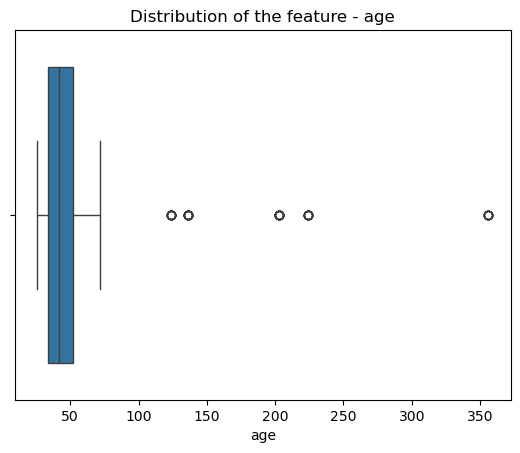

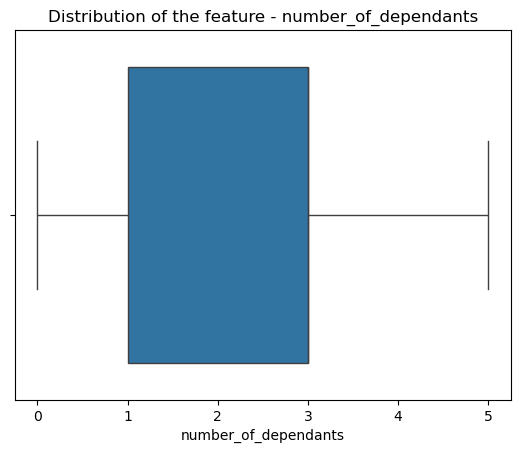

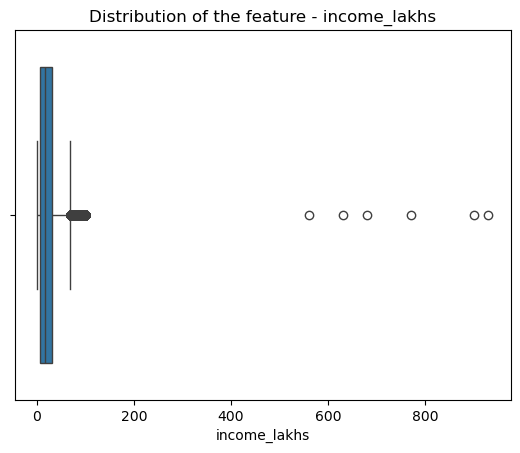

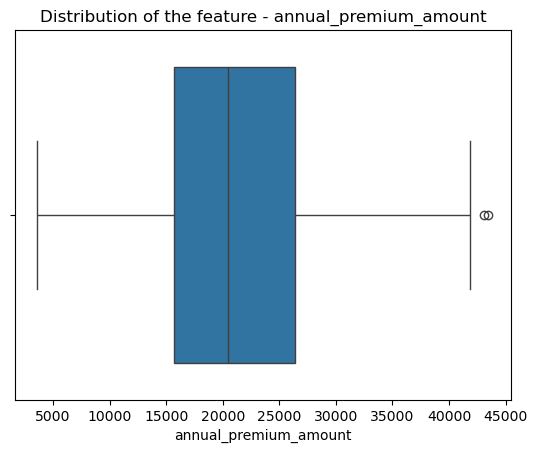

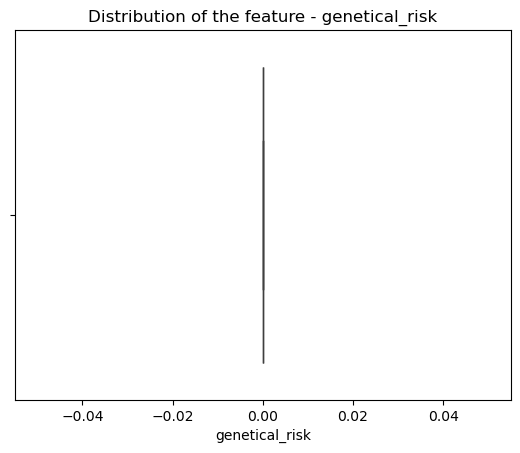

In [34]:
# Plotting box plot for each numerical columns to detect outliers

for col in numeric_columns:
    sns.boxplot(data=df,x=col)
    plt.title(f'Distribution of the feature - {col}')
    plt.show()

As seen above, outliers are present in the `income_lakhs` column. This is also demonstrated by the box plot shown above.

#### Age

In [35]:
# Before
df['age'].unique()

array([ 26,  29,  49,  30,  56,  33,  43,  59,  46,  68,  60,  27,  36,
        28,  32,  55,  35,  52,  40,  50,  41,  67,  37,  34,  54,  42,
        45,  44,  57,  38,  31,  58,  48,  51, 224,  47,  39,  53,  66,
        64,  65,  62,  61,  70,  72,  69,  71, 124,  63, 136, 203, 356])

In [36]:
# Selecting only the rows where age <= 100. Because age > 100 is outlier

df1 = df[df['age'] <= 100]
df1.reset_index(inplace=True,drop=True)

In [37]:
# After
df1['age'].unique()

array([26, 29, 49, 30, 56, 33, 43, 59, 46, 68, 60, 27, 36, 28, 32, 55, 35,
       52, 40, 50, 41, 67, 37, 34, 54, 42, 45, 44, 57, 38, 31, 58, 48, 51,
       47, 39, 53, 66, 64, 65, 62, 61, 70, 72, 69, 71, 63])

#### Income

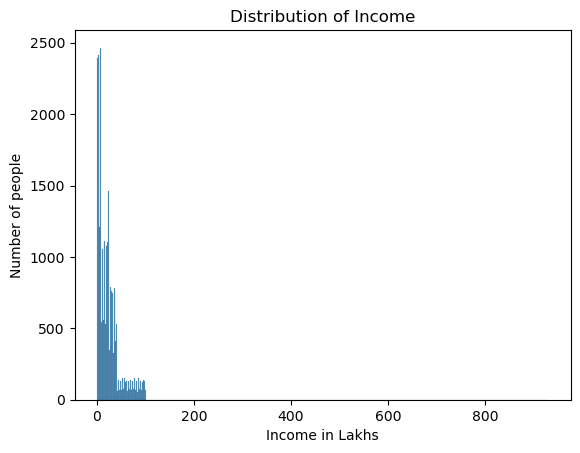

In [38]:
# Distribution of Income using Histogram

sns.histplot(data=df1,x='income_lakhs')
plt.title('Distribution of Income')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

In [39]:
# Determining Lower Salary Boundary and Upper Salary Boundary using IQR Method

# Quartile 1 and Quartile 3

q1 = np.percentile(df1['income_lakhs'],25)
q3 = np.percentile(df1['income_lakhs'],75)
print(f'Q1 -> {q1}\nQ3 -> {q3}')

# Inter Qurartile Range

iqr = q3-q1
print('IQR ->',iqr)

# Lower and Upper boundary using IQR

lower_boundary = q1 - (iqr * 1.5)
upper_boundary = q3 + (iqr * 1.5)
print(f'Lower Boundary -> {lower_boundary}\nUpper Boundary -> {upper_boundary}')

Q1 -> 7.0
Q3 -> 32.0
IQR -> 25.0
Lower Boundary -> -30.5
Upper Boundary -> 69.5


NOTE:

The current upper boundary is too low. Therefore, consultation with the business team will be conducted to determine the optimal upper boundary for identifying outliers in the income_lakhs column.

It has been decided that the upper boundary will be set at 1 crore (i.e., 100 lakhs). Any values exceeding this threshold will be considered outliers.

In [40]:
# Selecting only the rows where income <= 100 lakhs. Because income > 100 lakhs is outlier

income_threshold = 100
df2 = df1[df1['income_lakhs'] <= income_threshold]

In [41]:
df2.reset_index(drop=True,inplace=True)

In [42]:
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29817,60,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,25L - 40L,26,High blood pressure,Gold,26370,0
29818,40,Female,Southeast,Unmarried,0,Overweight,Regular,Salaried,10L - 25L,16,Diabetes & Thyroid,Gold,29496,0
29819,37,Female,Northwest,Unmarried,0,Obesity,No Smoking,Salaried,<10L,4,No Disease,Bronze,10957,0
29820,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Thyroid,Gold,27076,0


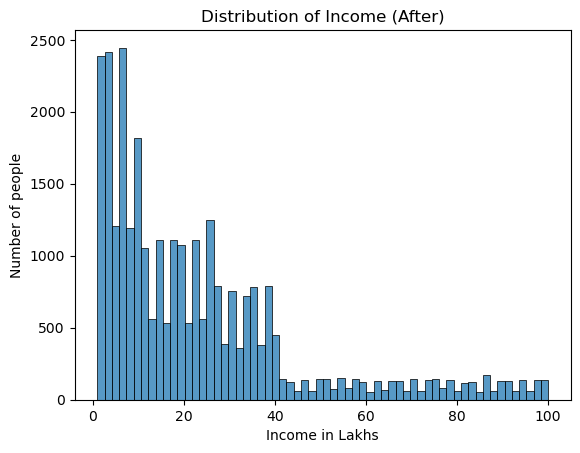

In [43]:
# After Treating outliers in 'income_lakhs' columns

sns.histplot(data=df2,x='income_lakhs')
plt.title('Distribution of Income (After)')
plt.xlabel('Income in Lakhs')
plt.ylabel('Number of people')
plt.show()

## EDA

Exploratory Data Analysis (EDA) is performed as follows:

- Univariate analysis on numeric columns
- Univariate analysis on categorical columns
- Bivariate analysis on numeric columns
- Bivariate analysis on categorical columns

### Univariate Analysis - Numeric Columns

The distribution of numerical columns will be plotted using histograms.

In [44]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

In [45]:
# Number of columns in the grid layout (fixed at 3 columns)
n_cols = 3 

# Calculate the number of rows required for the grid, based on the total number of numeric columns
n_rows = math.ceil(len(numeric_columns)/ n_cols)

# Print the grid dimensions (rows x columns)
print(f"Grid Dimension: {n_rows} rows and {n_cols} columns")

Grid Dimension: 2 rows and 3 columns


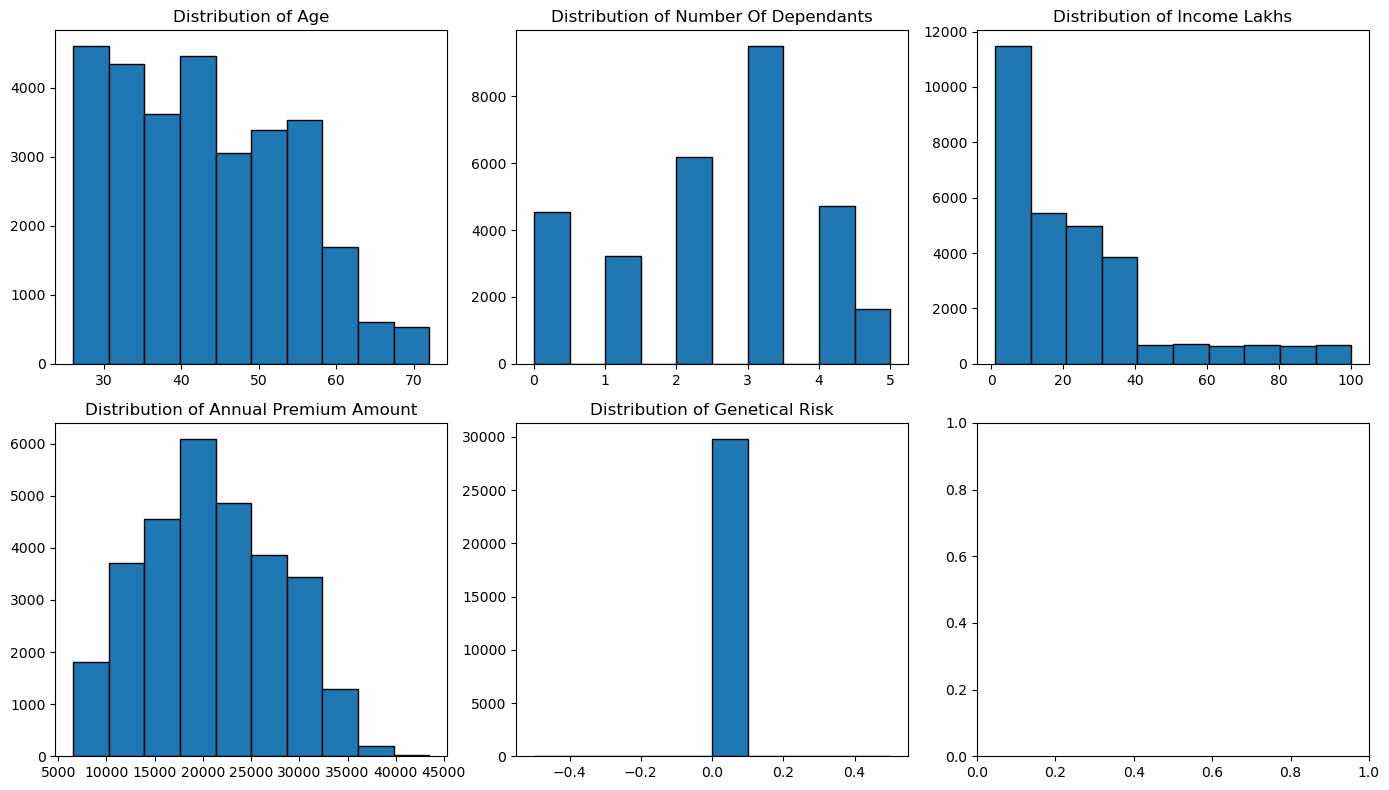

In [46]:
# Create subplots with the specified number of rows and columns
fig , ax = plt.subplots(n_rows,n_cols,figsize=(14,8))

# Flatten the array of axes for easy indexing and plotting
ax = ax.flatten()

# Loop through each numeric column to plot its distribution
for i in range(len(numeric_columns)):
    col = numeric_columns[i]
    # Format column name for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')

    # Plot a histogram for the current numeric column with black edges
    ax[i].hist(x=df2[col],edgecolor='black')

    # Set the title for the subplot to indicate the column being plotted
    ax[i].set_title(f'Distribution of {x_ax}')

# Adjust layout to prevent overlapping labels and ensure proper spacing between plots
plt.tight_layout()
plt.show()

### Univariate Analysis - Categorical Columns

The distribution of categorical columns will be plotted using barcharts.

In [47]:
df2[cat_columns]

,gender,region,marital_status,bmi_category,smoking_status,employment_status,income_level,medical_history,insurance_plan
0,Male,Northwest,Unmarried,Normal,No Smoking,Salaried,<10L,Diabetes,Bronze
1,Female,Southeast,Married,Obesity,Regular,Salaried,<10L,Diabetes,Bronze
2,Female,Northeast,Married,Normal,No Smoking,Self-Employed,10L - 25L,High blood pressure,Silver
3,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,No Disease,Gold
4,Male,Northeast,Married,Obesity,Occasional,Self-Employed,10L - 25L,Diabetes,Bronze
...,...,...,...,...,...,...,...,...,...
29817,Female,Northwest,Married,Normal,No Smoking,Self-Employed,25L - 40L,High blood pressure,Gold
29818,Female,Southeast,Unmarried,Overweight,Regular,Salaried,10L - 25L,Diabetes & Thyroid,Gold
29819,Female,Northwest,Unmarried,Obesity,No Smoking,Salaried,<10L,No Disease,Bronze
29820,Female,Southeast,Married,Normal,No Smoking,Salaried,> 40L,Thyroid,Gold


In previous runs, the x-axis labels for the `medical_history` column were misaligned in the plots. To resolve this issue, the values will be mapped using the dictionary *ds_dict* as shown below.

In [48]:
ds_dict = {'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

ds_dict

{'No Disease': 'NO DISEASE',
 'Diabetes': 'DB',
 'High blood pressure': 'HBP',
 'Thyroid': 'THY',
 'Heart disease': 'HD',
 'Diabetes & High blood pressure': 'DB & HBP',
 'High blood pressure & Heart disease': 'HBP & HD',
 'Diabetes & Thyroid': 'DB & THY',
 'Diabetes & Heart disease': 'DB & HD'}

In [49]:
# Showing how mapping works

print('Without Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index))
print('\n','*'*100,'\n')
print('With Mapping:')
print(list(df2['medical_history'].value_counts(normalize=True).index.map(ds_dict)))

Without Mapping:
['Diabetes', 'High blood pressure', 'Thyroid', 'No Disease', 'Heart disease', 'Diabetes & High blood pressure', 'High blood pressure & Heart disease', 'Diabetes & Thyroid', 'Diabetes & Heart disease']

 **************************************************************************************************** 

With Mapping:
['DB', 'HBP', 'THY', 'NO DISEASE', 'HD', 'DB & HBP', 'HBP & HD', 'DB & THY', 'DB & HD']


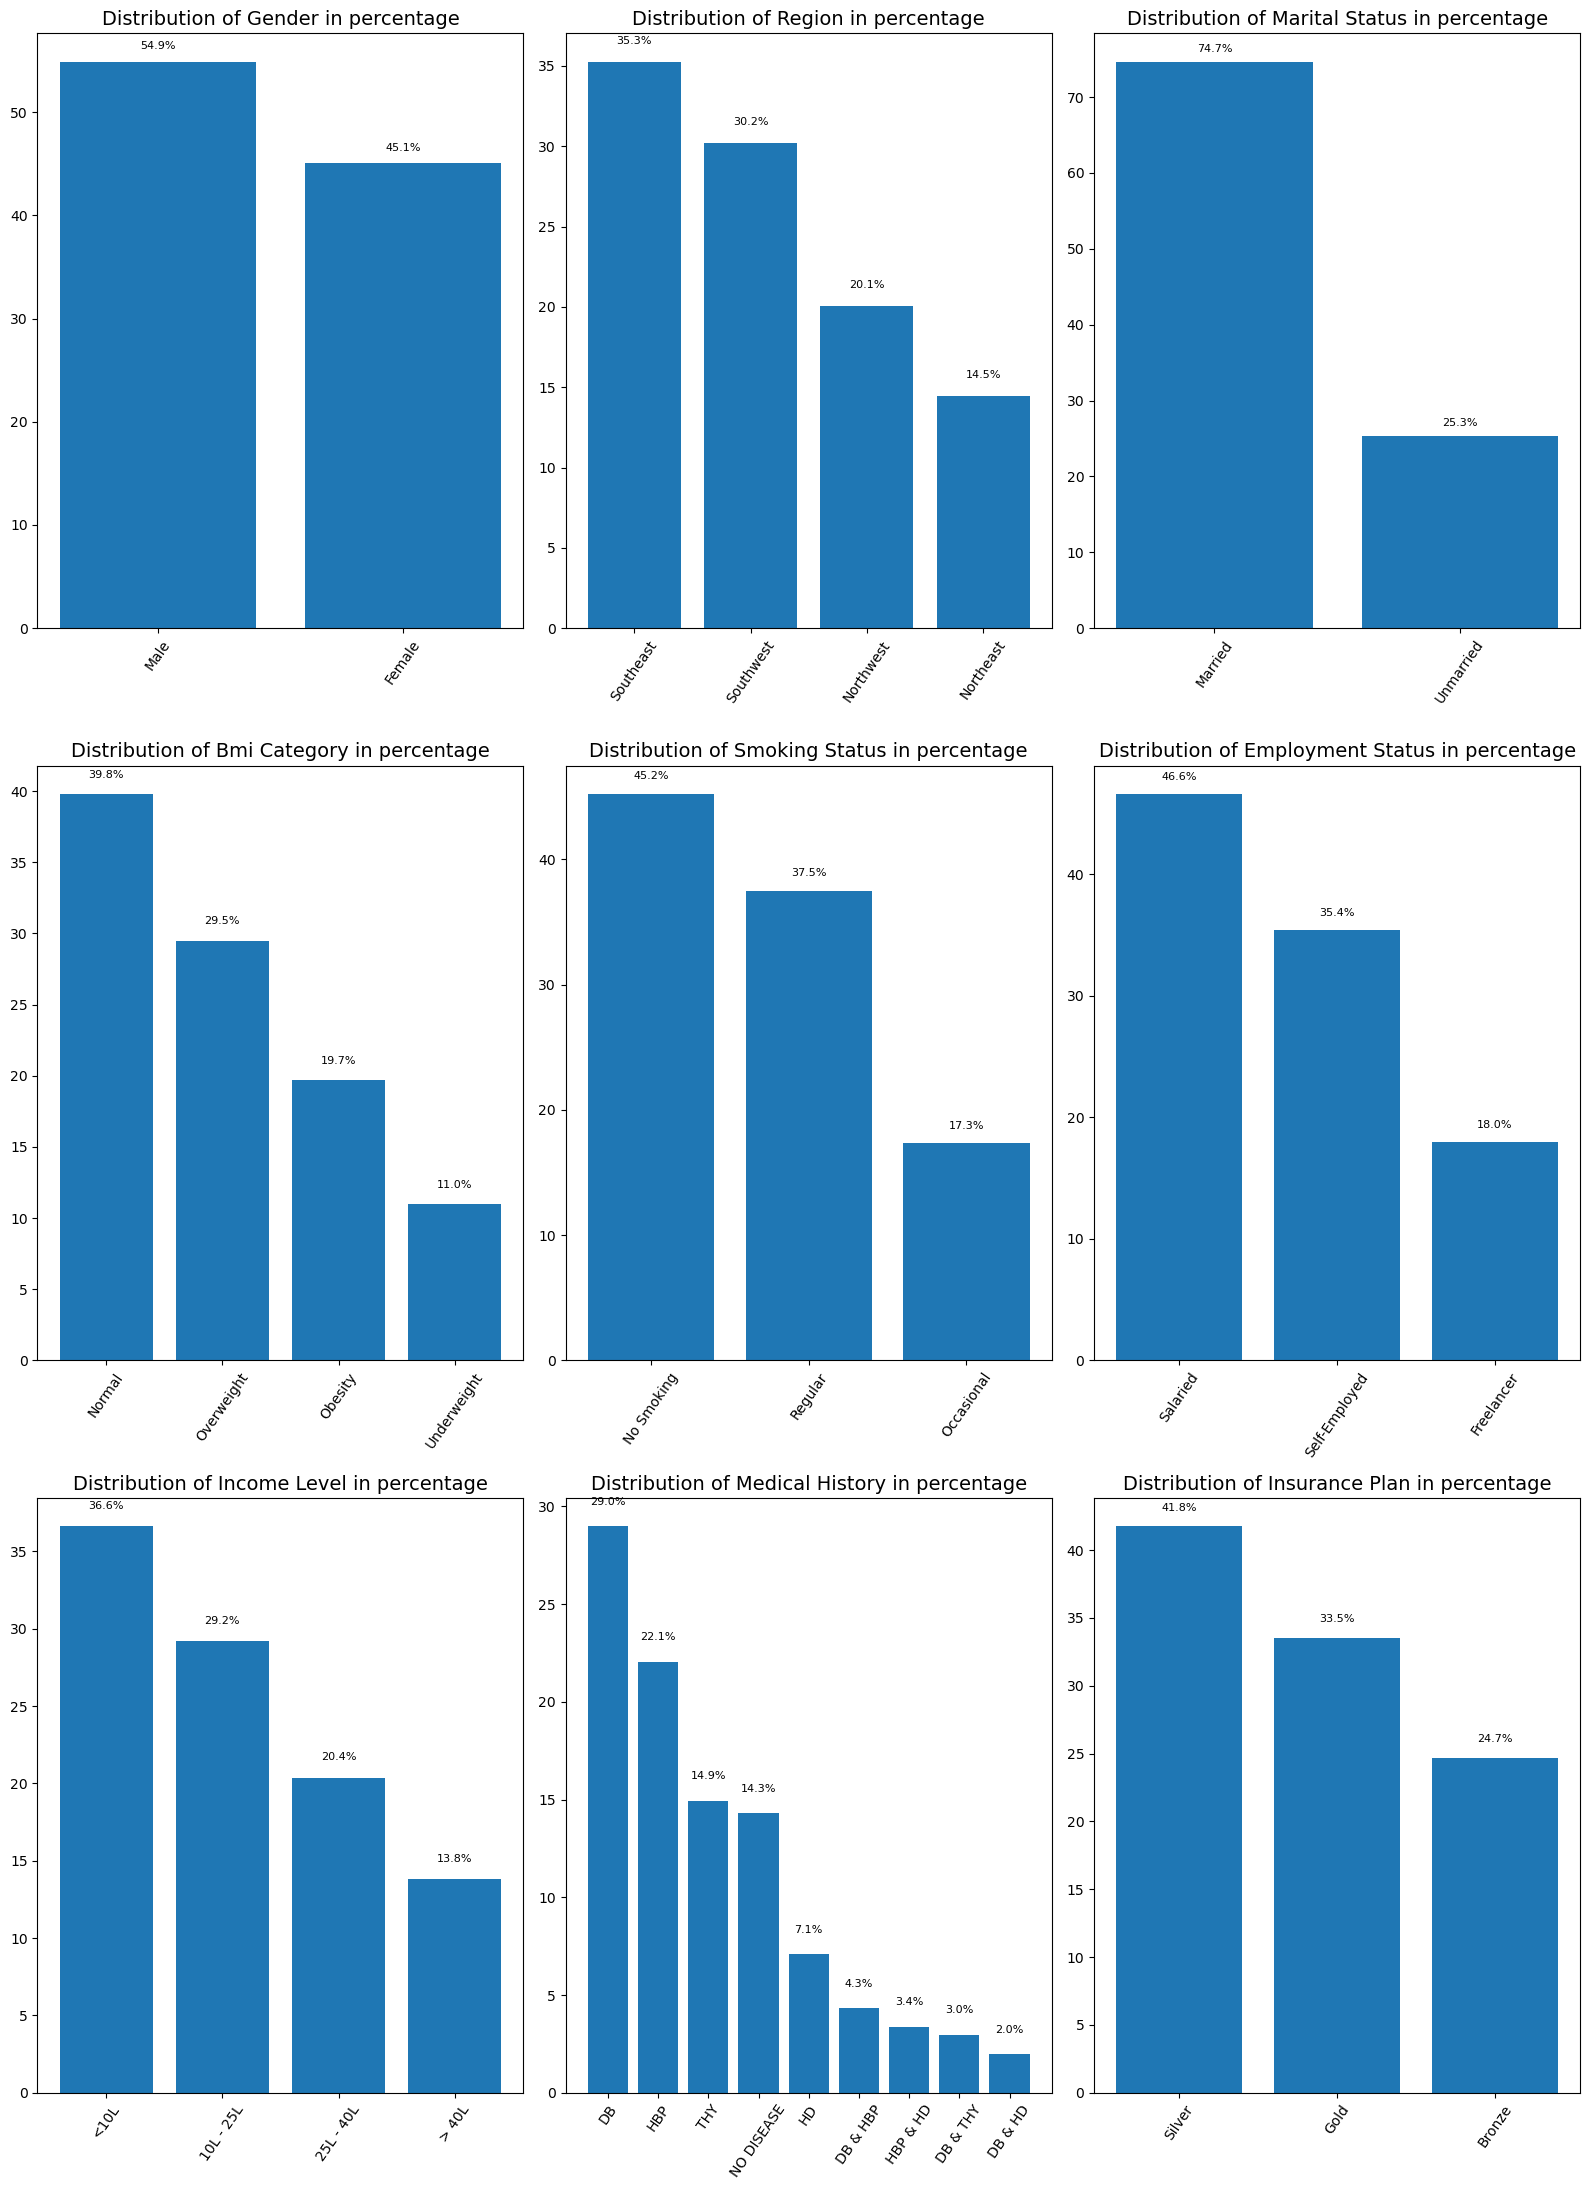

In [50]:
# Plotting Distribution for all categorical columns

fig, ax = plt.subplots(3,3,figsize=(16,22))

# Iterator initiation to retrive one value at a time
it = iter(cat_columns)

for i in range(3):
    for j in range(3):
        # To retrive one value at a time
        col = next(it)
        
        # Format column name for display: capitalize first letter of each word and replace underscores with spaces
        x_ax = col.title().replace('_',' ')

        # Map the 'medical_history' column using ds_dict to ensure consistent and clean labels for plotting
        
        if col == 'medical_history':
            x_val = df2[col].value_counts(normalize=True).index.map(ds_dict)
        else:
            x_val = df2[col].value_counts(normalize=True).index
            
        h_val = df2[col].value_counts(normalize=True).values * 100
        ax[i,j].bar(x=x_val,height=h_val)
        ax[i,j].set_title(f'Distribution of {x_ax} in percentage',fontsize=14)
        ax[i,j].tick_params(axis='x', rotation=55)
        
        # Annotate each bar with its corresponding percentage value for better interpretability
        for idx, val in enumerate(h_val):
            ax[i,j].text(idx, val + 1, f'{round(val,1)}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Bivariate Analysis - Numeric Columns

The relationship between each numerical column (excluding the `annual_premium_amount` column itself) and the `annual_premium_amount` column will be plotted to analyze potential correlations.

In [51]:
df2[numeric_columns]

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
0,26,0,6,9053,0
1,29,2,6,16339,0
2,49,2,20,18164,0
3,30,3,77,20303,0
4,56,3,14,15610,0
...,...,...,...,...,...
29817,60,3,26,26370,0
29818,40,0,16,29496,0
29819,37,0,4,10957,0
29820,47,2,82,27076,0


In [52]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

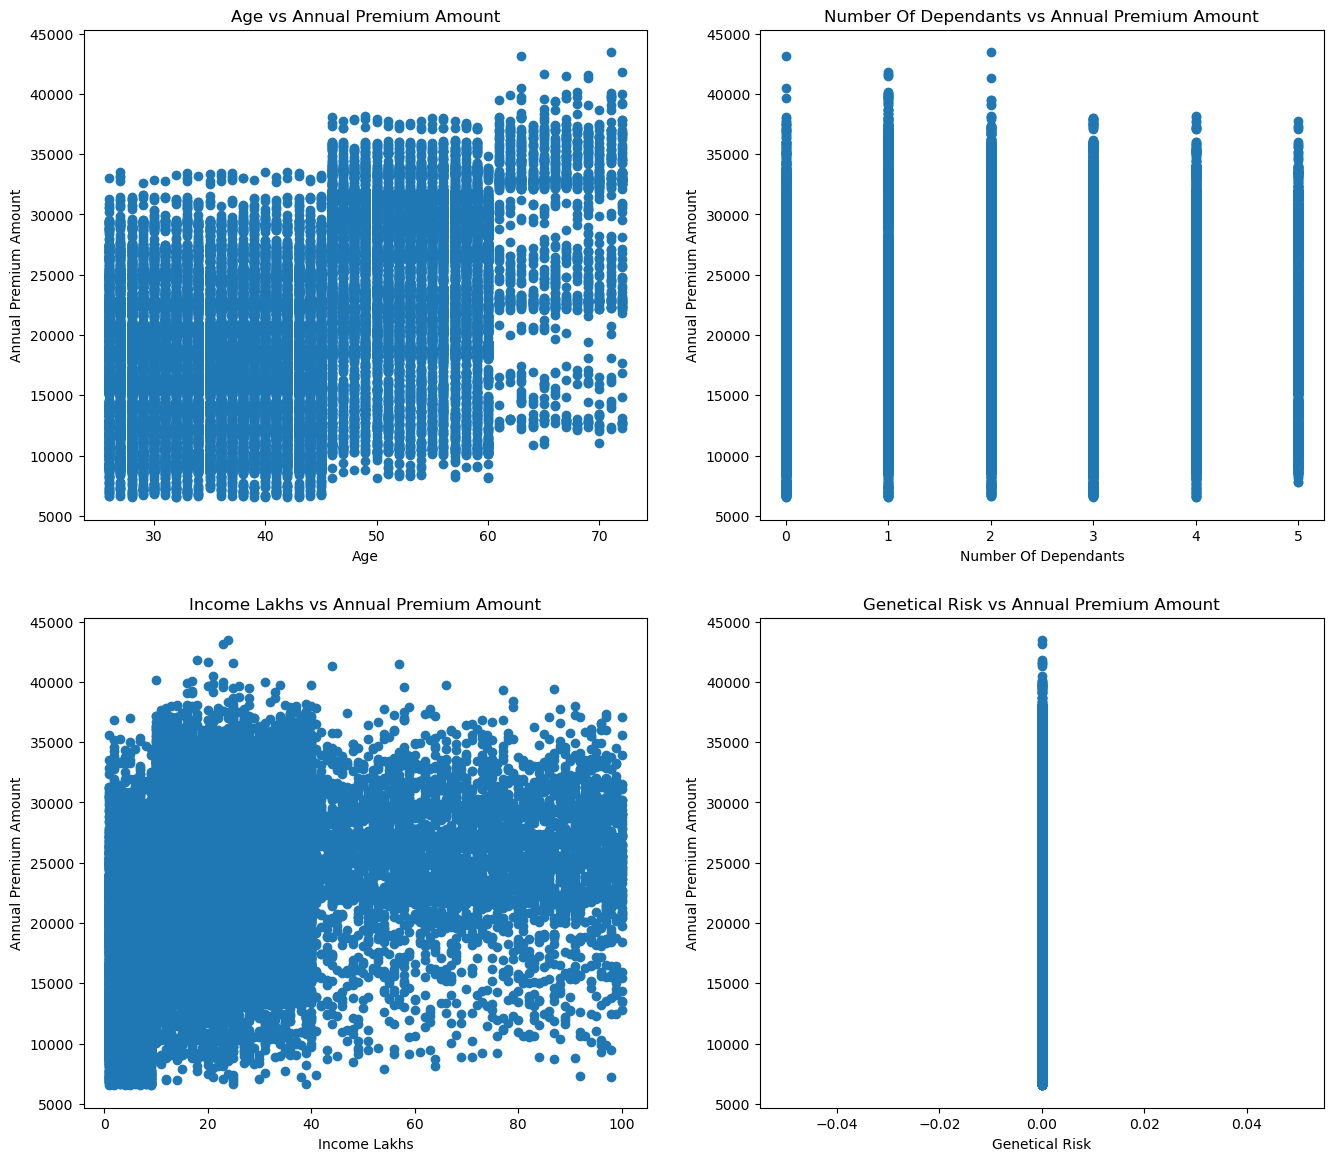

In [53]:
# Plotting the scatter plots

fig, ax = plt.subplots(2,2,figsize=(16,14))

ax=ax.flatten()

temp = list(numeric_columns).remove('annual_premium_amount')

for i in range(len(numeric_columns)-1):
    col = numeric_columns.drop('annual_premium_amount')[i]
    
    # Format column names for display: capitalize first letter of each word and replace underscores with spaces
    x_ax = col.title().replace('_',' ')
    y_ax = 'annual_premium_amount'.title().replace('_',' ')
    
    ax[i].scatter(x=df2[col],y=df2['annual_premium_amount'])
    ax[i].set_title(f'{x_ax} vs {y_ax}')
    ax[i].set_xlabel(x_ax)
    ax[i].set_ylabel(y_ax)

### Bivariate Analysis - Categorical

The relationship between the categorical columns `income_level` and `insurance_plan` will be explored using multiple approaches:

* Cross-tabulation
* Grouped Bar Chart
* Stacked Bar Chart
* Heatmap
  

In [54]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


#### Cross-tabulation

The frequency distribution between `income_level` and `insurance_plan` will be examined using a cross-tabulation, which will display the number of individuals in each combination of income level and insurance plan.

In [55]:
ct = pd.crosstab(df['income_level'],df['insurance_plan'])
ct

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,806,3560,4361
25L - 40L,304,2635,3145
<10L,6067,527,4350
> 40L,214,3296,621


In [56]:
# Reorder rows and columns
row_order = ['<10L', '10L - 25L', '25L - 40L', '> 40L']
col_order = ['Bronze', 'Silver', 'Gold']

In [57]:
# Reordered CT

ct = ct.loc[row_order, col_order]
ct

insurance_plan,Bronze,Silver,Gold
income_level,,,
<10L,6067,4350,527
10L - 25L,806,4361,3560
25L - 40L,304,3145,2635
> 40L,214,621,3296


#### Grouped Bar Chart

The count of each `insurance_plan` across different `income_level` categories will be visualized using grouped bar charts, where each income level will have side-by-side bars representing the different insurance plans for easy comparison.

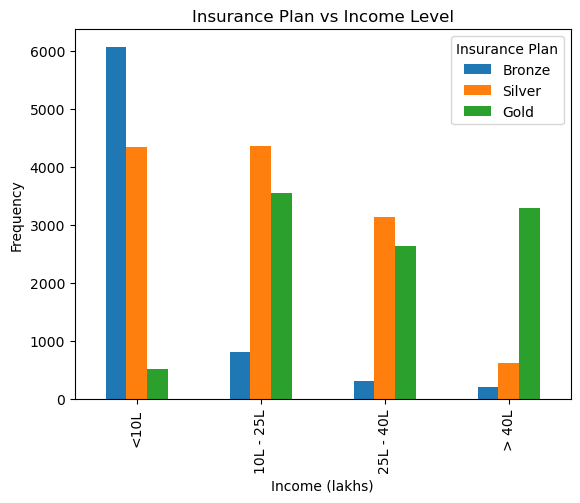

In [58]:
ct.plot(kind='bar')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Stacked Bar Chart

The distribution of `insurance_plan` within each `income_level` will be represented in a stacked bar chart format, helping to understand the proportion of each plan type within the income categories.

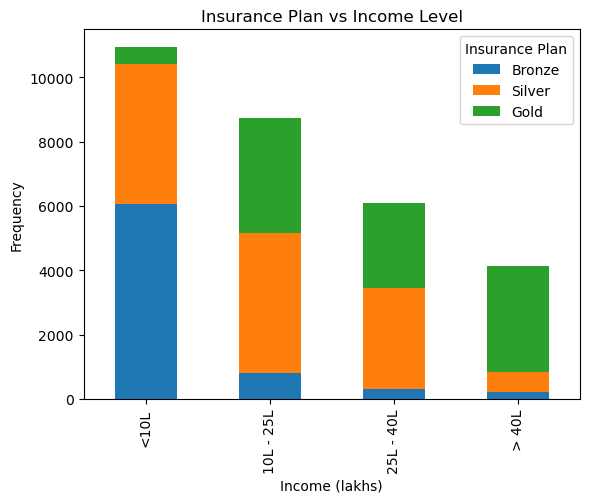

In [59]:
ct.plot(kind='bar',stacked=True)
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Income (lakhs)')
plt.ylabel('Frequency')
plt.legend(title='Insurance Plan')
plt.show()

#### Heatmap

The intensity of the relationship between `insurance_plan` and `income_level` will be visualized using a heatmap, where the cells are color-coded based on frequency to highlight patterns and concentrations in the data.

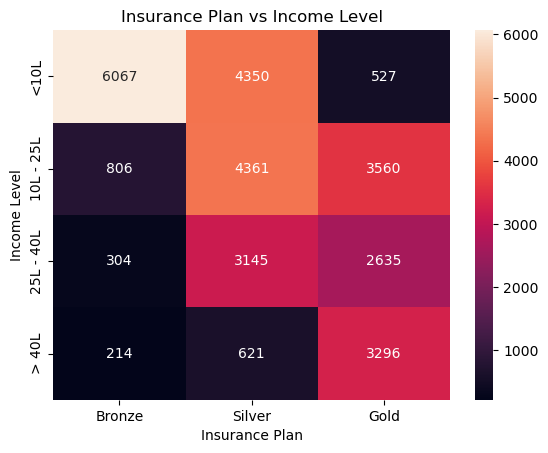

In [60]:
sns.heatmap(ct,annot=True,fmt='0')
plt.title('Insurance Plan vs Income Level')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.show()

## Feature Engineering

The following feature engineering steps were performed:

- Created new features as required
- Transformed features, including encoding categorical variables
- Selected important features using statistical methods such as Variance Inflation Factor (VIF) and correlation analysis

### Feature Creation - 'total_risk_score'

In this we created a new feature `total_risk_score` from `medical_history` column

In [61]:
# Extract all distinct medical conditions listed in the dataset

df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

The following risk scores, as provided by the business, will be assigned to the corresponding medical conditions:

* Heart disease: 8
* Diabetes: 6
* High blood pressure: 6
* Thyroid: 5
* No Disease: 0
* None: 0

In [62]:
df3 = df2.copy()
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [63]:
# Split the 'medical_history' column into 'disease1' and 'disease2' using '&' as the delimiter

df3[['disease1','disease2']] = df3['medical_history'].str.lower().str.split(' & ',expand=True)
df3.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,None


In [64]:
# Risk Score Dictionary

risk_score_dict = {
    'heart disease' : 8,
'diabetes' : 6,
'high blood pressure' : 6,
'thyroid' : 5,
'no disease' : 0,
None : 0
}

In [65]:
# Mapping each disease to its corresponding score using a predefined dictionary

df3['disease1_score'] = df3['disease1'].map(risk_score_dict)
df3['disease2_score'] = df3['disease2'].map(risk_score_dict)
df3.sample(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,disease1_score,disease2_score
21216,30,Female,Southwest,Married,3,Normal,No Smoking,Salaried,> 40L,73,Diabetes,Bronze,9209,0,diabetes,None,6,0
3797,36,Male,Southwest,Married,4,Obesity,Regular,Self-Employed,25L - 40L,30,High blood pressure,Silver,22069,0,high blood pressure,None,6,0


In [66]:
# Check if all diseases have been assigned a score and identify any missing values

print('Unique Scores in Disease1 -> ',df3['disease1_score'].unique())
print('Unique Scores in Disease2 -> ',df3['disease2_score'].unique())

Unique Scores in Disease1 ->  [6 0 5 8]
Unique Scores in Disease2 ->  [0 6 8 5]


Since there are no NaN values, it can be concluded that all entries in the `disease1` and `disease2` columns have been successfully mapped.

In [67]:
# Calculating the total risk score by summing 'disease1_score' and 'disease2_score'

df3['total_risk_score'] = df3['disease1_score'] + df3['disease2_score']
df3.sample(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,disease1_score,disease2_score,total_risk_score
13237,50,Male,Southwest,Married,3,Overweight,Regular,Freelancer,10L - 25L,17,Diabetes,Gold,31328,0,diabetes,None,6,0,6
23325,55,Male,Northwest,Unmarried,1,Overweight,Regular,Freelancer,<10L,5,No Disease,Silver,21832,0,no disease,None,0,0,0
25287,36,Female,Southwest,Married,3,Obesity,Regular,Self-Employed,25L - 40L,34,High blood pressure,Silver,22392,0,high blood pressure,None,6,0,6
28189,56,Male,Southeast,Married,2,Normal,No Smoking,Salaried,10L - 25L,12,High blood pressure,Gold,27003,0,high blood pressure,None,6,0,6


The following columns are being dropped as they are no longer needed: `medical_history`, `disease1`, `disease2`, `disease1_score`, and `disease2_score`.

In [68]:
cols_to_drop = ['medical_history', 'disease1', 'disease2', 'disease1_score', 'disease2_score']
df4 = df3.drop(cols_to_drop,axis=1)
df4.reset_index(drop=True,inplace=True)
df4

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,0,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,0,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,0,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,0,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Bronze,15610,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29817,60,Female,Northwest,Married,3,Normal,No Smoking,Self-Employed,25L - 40L,26,Gold,26370,0,6
29818,40,Female,Southeast,Unmarried,0,Overweight,Regular,Salaried,10L - 25L,16,Gold,29496,0,11
29819,37,Female,Northwest,Unmarried,0,Obesity,No Smoking,Salaried,<10L,4,Bronze,10957,0,0
29820,47,Female,Southeast,Married,2,Normal,No Smoking,Salaried,> 40L,82,Gold,27076,0,5


### Feature Cleaning & Transformation

The following transformations were applied to the dataset features:

- Label Encoding for ordinal categorical variables (to preserve order)
- One Hot Encodingfor nominal categorical variables (to avoid introducing ordinal relationships)

In [69]:
df5 = df4.copy()
df5.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,0,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,0,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,0,6
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,0,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Bronze,15610,0,6


#### Label Encodig - 'income_level'

In [70]:
# Extract all distinct income levels listed in the dataset

df5.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [71]:
# Income level dictionary

income_level_dict =  {
        '<10L' : 1,
        '10L - 25L' : 2,
        '25L - 40L' : 3,
        '> 40L' : 4
    }

In [72]:
# Mapping each income level to a value using a predefined dictionary

df5['income_level'] = df5['income_level'].map(income_level_dict)

In [73]:
# After mapping

df5.income_level.unique()

array([1, 2, 4, 3])

#### Label Encodig - 'insurance_plan'

In [74]:
# Extract all distinct insurance plan listed in the dataset

df5.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [75]:
# Insurance Plan dictionary

insurance_plan_dict = {
        'Bronze' : 1,
        'Silver' : 2,
        'Gold' : 3,
    }

In [76]:
# Mapping each insurance plan to a value using a predefined dictionary

df5['insurance_plan'] = df5['insurance_plan'].map(insurance_plan_dict)

In [77]:
# After mapping

df5.insurance_plan.unique()

array([1, 2, 3])

#### One Hot Encoding

In [78]:
# Selecting columns to perform one hot encoding

cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
cols_to_encode

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']

In [79]:
# Performing One Hot Encoding on df5

df6 = pd.get_dummies(df5,columns = cols_to_encode,dtype=int,drop_first=True)

In [80]:
df6.sample(5)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
2468,38,2,1,4,1,10275,0,0,0,0,0,1,0,0,0,0,0,1,1,0
28378,60,4,2,14,3,27347,0,5,1,1,0,0,0,0,0,1,0,0,1,0
25514,39,3,2,12,2,22572,0,11,1,0,1,0,0,0,1,0,0,1,0,0
10888,52,4,4,69,2,21796,0,5,1,1,0,0,0,0,0,0,0,1,0,1
451,54,3,3,38,2,19001,0,6,0,0,0,1,0,0,0,0,0,0,0,1


In [81]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29822 entries, 0 to 29821
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   age                              29822 non-null  int64
 1   number_of_dependants             29822 non-null  int64
 2   income_level                     29822 non-null  int64
 3   income_lakhs                     29822 non-null  int64
 4   insurance_plan                   29822 non-null  int64
 5   annual_premium_amount            29822 non-null  int64
 6   genetical_risk                   29822 non-null  int64
 7   total_risk_score                 29822 non-null  int64
 8   gender_Male                      29822 non-null  int64
 9   region_Northwest                 29822 non-null  int64
 10  region_Southeast                 29822 non-null  int64
 11  region_Southwest                 29822 non-null  int64
 12  marital_status_Unmarried         29822 non-nul

In [82]:
# Showing all the non-encoded columns and one encoded columns from each category

sampled_encoded_cols_index = [0,1,2,3,4,5,6,7,8,11,12,15,17,19]

df6.iloc[0:5,sampled_encoded_cols_index]

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Southwest,marital_status_Unmarried,bmi_category_Underweight,smoking_status_Regular,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,6,1,0,1,0,0,0
1,29,2,1,6,1,16339,0,6,0,0,0,0,1,0
2,49,2,2,20,2,18164,0,6,0,0,0,0,0,1
3,30,3,4,77,3,20303,0,0,0,0,0,0,0,0
4,56,3,2,14,1,15610,0,6,1,0,0,0,0,1


### Feature Selection

- To identify the most relevant features, both pairwise correlations and multicollinearity will be analyzed.  
- *Correlation* analysis will be used to detect linear relationships, while *Variance Inflation Factor (VIF)* will be employed to identify multicollinearity.  
- Prior to these analyses, features will be scaled to ensure comparability across variables.

In [83]:
# Before Scaling the features

df7 = df6.copy()
df7.sample(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
330,45,3,2,11,2,20200,0,5,1,0,1,0,0,0,1,0,0,1,0,0
2759,70,1,1,6,2,23097,0,6,0,0,1,0,0,0,0,0,0,0,0,1
13815,48,2,4,54,3,31541,0,6,0,0,1,0,0,1,0,0,1,0,1,0


In [84]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

The following columns will be scaled: `age`, `number_of_dependants`, `income_level`, `income_lakhs`, `insurance_plan`, `'genetical_risk'`, `total_risk_score`.  

Scaling type : Minmax scaling

In [85]:
# Scaling using 'MinMaxScaler'

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk', 'total_risk_score']
mms = MinMaxScaler()
df7[cols_to_scale] = mms.fit_transform(df7[cols_to_scale])

#### Correlation

In [86]:
# Correlation Matrix between features

cr = df7.corr()
cr

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,-0.017614,0.033455,0.024253,0.310446,0.484715,NaN,0.002473,-0.003699,0.001752,-0.002130,-0.003622,-0.123857,0.014732,0.017585,0.005224,-0.053572,-0.126481,-0.198537,0.270621
number_of_dependants,-0.017614,1.000000,-0.000009,-0.000640,0.010334,0.015969,NaN,0.106168,-0.000594,-0.002981,0.000732,0.007047,-0.777352,0.019413,0.014560,-0.021186,0.011848,0.013306,0.012497,-0.015319
income_level,0.033455,-0.000009,1.000000,0.906027,0.575543,0.457965,NaN,0.009162,0.087234,-0.003207,0.001624,0.008060,-0.008038,-0.013072,0.000403,0.009439,-0.008517,0.027486,-0.153555,0.158281
income_lakhs,0.024253,-0.000640,0.906027,1.000000,0.491785,0.385215,NaN,0.002320,0.064060,-0.004417,0.000914,0.006266,-0.005109,-0.010316,0.001635,0.004484,-0.002957,0.018637,-0.115155,0.121798
insurance_plan,0.310446,0.010334,0.575543,0.491785,1.000000,0.882571,NaN,0.001329,0.069102,-0.000996,0.006580,-0.006797,-0.053047,0.014033,0.025969,-0.014648,-0.029196,-0.017796,-0.152740,0.185159
annual_premium_amount,0.484715,0.015969,0.457965,0.385215,0.882571,1.000000,NaN,0.209361,0.132898,-0.004529,0.007190,-0.005766,-0.103286,0.188450,0.086748,-0.053967,-0.059392,0.136671,-0.179511,0.226210
genetical_risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_risk_score,0.002473,0.106168,0.009162,0.002320,0.001329,0.209361,NaN,1.000000,-0.005953,-0.010381,0.002480,0.005633,-0.140899,-0.010069,-0.004903,0.006440,0.005484,0.003338,-0.009321,0.014835
gender_Male,-0.003699,-0.000594,0.087234,0.064060,0.069102,0.132898,NaN,-0.005953,1.000000,-0.003620,-0.004893,0.004782,0.001761,-0.020570,0.103029,-0.029880,-0.096120,0.372381,0.004947,0.002606
region_Northwest,0.001752,-0.002981,-0.003207,-0.004417,-0.000996,-0.004529,NaN,-0.010381,-0.003620,1.000000,-0.369870,-0.329590,0.001498,0.001041,0.000390,-0.007454,-0.000612,0.001156,0.000872,0.000298


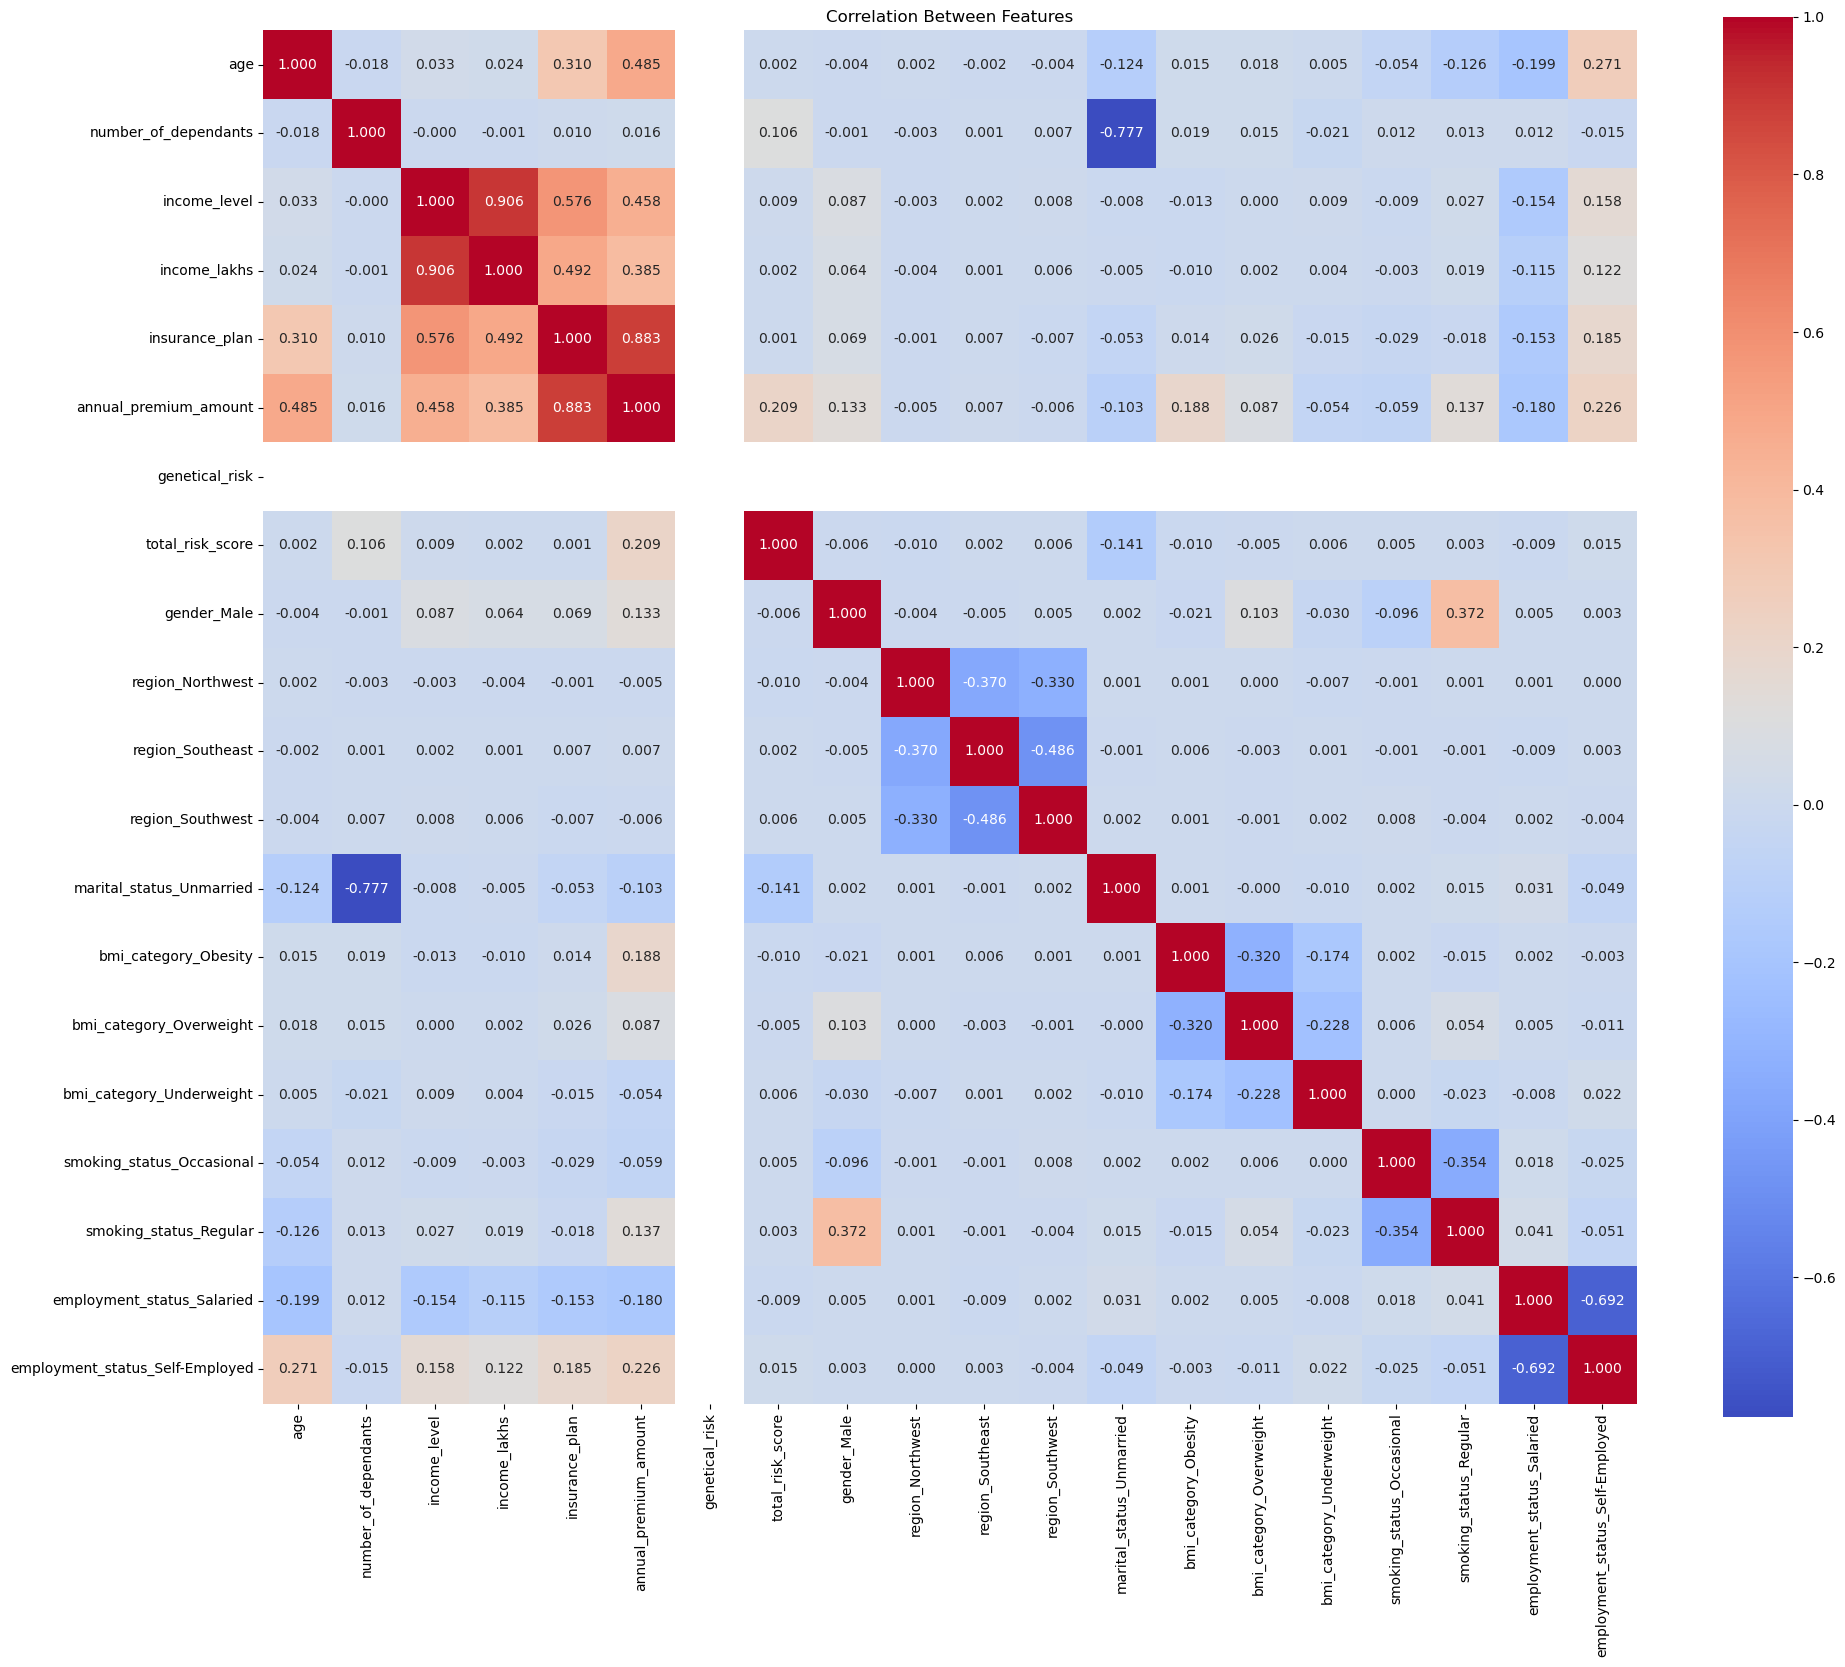

In [87]:
# Correlation Matrix displayed as a Heatmap

plt.figure(figsize=(20,20))
sns.heatmap(cr, annot=True, fmt='.3f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Between Features')
plt.tight_layout()
plt.show()

In [88]:
# Display features that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount']

age                                0.484715
income_level                       0.457965
income_lakhs                       0.385215
insurance_plan                     0.882571
annual_premium_amount              1.000000
total_risk_score                   0.209361
employment_status_Self-Employed    0.226210
Name: annual_premium_amount, dtype: float64

In [89]:
# Extract the feature names (index labels) that have a high correlation (|correlation| > 0.2) with 'annual_premium_amount'

cr[abs(cr['annual_premium_amount']) > 0.2]['annual_premium_amount'].index

Index(['age', 'income_level', 'income_lakhs', 'insurance_plan',
       'annual_premium_amount', 'total_risk_score',
       'employment_status_Self-Employed'],
      dtype='object')

**Observation**

Based on the correlation heatmap, a ***strong positive correlation*** with `annual_premium_amount` is observed for the features `age`, `income_level`, `income_lakhs`, `insurance_plan`, `total_risk_score` and `employment_status_Self-Employed` suggesting that these variables may significantly influence premium prediction.

***No strong negative correlation was observed***, indicating that no variables show a clear inverse relationship with premium amounts.

#### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) will be checked to detect and address multicollinearity among the features.


In [90]:
df7.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [91]:
# Calculate VIF for each feature and store the results in a new DataFrame

# Initialize a dictionary to store feature names and their corresponding VIF scores
vif_dict = {'features':[],'vif_score':[]}

# Exclude the target variable from VIF calculation
temp_df = df7.drop('annual_premium_amount',axis=1)

# Loop through each feature to compute VIF
for i,col in enumerate(temp_df.columns):
    # Calculate the Variance Inflation Factor for the current feature
    vif = variance_inflation_factor(temp_df,i)

    # Append the feature name and its VIF score to the dictionary
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

C:\Users\91948\anaconda3\envs\phipe\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [92]:
# Convert the VIF dictionary into a DataFrame for better readability and analysis
vif_df = pd.DataFrame(vif_dict)

# Sort features by their VIF scores in descending order to identify highly collinear features
vif_df.sort_values(by='vif_score',ascending=False)

,features,vif_score
2,income_level,13.890522
3,income_lakhs,11.185596
1,number_of_dependants,6.278938
4,insurance_plan,5.271297
0,age,3.921783
6,total_risk_score,3.810619
17,employment_status_Salaried,3.177473
9,region_Southeast,2.980842
18,employment_status_Self-Employed,2.871687
10,region_Southwest,2.710097


After the Variance Inflation Factor (VIF) was calculated for all features, it was observed that both `income_level` and `income_lakhs` had VIF scores exceeding the commonly accepted threshold of 10, indicating the presence of high multicollinearity between them.

To address this issue and enhance model stability, the `income_level` feature was dropped, as it exhibited the higher VIF value of the two. This step was taken to reduce redundancy without significantly compromising the information contained in the dataset.

In [93]:
# Initialize a list to store highly collinear features to be removed later

high_vif_features  = []

In [94]:
# Identify the feature with the highest VIF score and add it to the removal list 'high_vif_features'

highest_vif_feature = vif_df['features'][vif_df['vif_score'].idxmax()]
high_vif_features.append(highest_vif_feature)
print(high_vif_features)

['income_level']


In [95]:
# Drop the most collinear feature from the temporary DataFrame

temp_df1 = temp_df.drop(['income_level'],axis=1).copy()
temp_df1

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29817,0.739130,0.6,0.252525,1.0,0.0,0.428571,0,1,0,0,0,0,0,0,0,0,0,1
29818,0.304348,0.0,0.151515,1.0,0.0,0.785714,0,0,1,0,1,0,1,0,0,1,1,0
29819,0.239130,0.0,0.030303,0.0,0.0,0.000000,0,1,0,0,1,1,0,0,0,0,1,0
29820,0.456522,0.4,0.818182,1.0,0.0,0.357143,0,0,1,0,0,0,0,0,0,0,1,0


The same process will be repeated until all VIF values are within the acceptable threshold.

In [96]:
# Recalculate VIF scores for the updated feature set

vif_dict = {'features':[],'vif_score':[]}

for i,col in enumerate(temp_df1.columns):
    vif = variance_inflation_factor(temp_df1,i)
    vif_dict['features'].append(col)
    vif_dict['vif_score'].append(vif)

# Create a DataFrame from the updated VIF scores
vif_df = pd.DataFrame(vif_dict)

# Sort VIF scores in descending order to identify next candidates for removal
vif_df.sort_values(by='vif_score',ascending=False)

C:\Users\91948\anaconda3\envs\phipe\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,features,vif_score
1,number_of_dependants,6.278147
3,insurance_plan,4.574625
0,age,3.863055
5,total_risk_score,3.808345
16,employment_status_Salaried,3.169218
8,region_Southeast,2.979899
17,employment_status_Self-Employed,2.866611
9,region_Southwest,2.708641
2,income_lakhs,2.678102
6,gender_Male,2.591439


All remaining features have acceptable VIF scores.

In [97]:
# Remove the previously identified high-VIF features from the original DataFrame.
final_df = df7.drop(high_vif_features,axis=1)

# Display the final cleaned dataset
final_df

,age,number_of_dependants,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,9053,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,16339,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,18164,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,20303,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,15610,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29817,0.739130,0.6,0.252525,1.0,26370,0.0,0.428571,0,1,0,0,0,0,0,0,0,0,0,1
29818,0.304348,0.0,0.151515,1.0,29496,0.0,0.785714,0,0,1,0,1,0,1,0,0,1,1,0
29819,0.239130,0.0,0.030303,0.0,10957,0.0,0.000000,0,1,0,0,1,1,0,0,0,0,1,0
29820,0.456522,0.4,0.818182,1.0,27076,0.0,0.357143,0,0,1,0,0,0,0,0,0,0,1,0


## Model Selection

The model selection process proceeded as follows:

1. Split the dataset into training and test sets.  
2. Trained different models on the training data.  
3. Used cross-validation to compare model performance.  
4. Tuned hyperparameters of the best model.  
5. Evaluated the final model’s performance on the test set. 

### Dataset Split

The dataset is divided as follows:

- Training set: 70%
- Test set: 30%

Split was done randomly with a fixed seed for reproducibility.

In [98]:
# Separate features and target variable

features = final_df.drop(['annual_premium_amount'],axis=1)
target = final_df['annual_premium_amount']

In [99]:
# Split the data into training and test sets

X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=42)

In [100]:
# Display the shape of training and test sets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (20875, 18), y_train shape: (20875,)
X_test shape: (8947, 18), y_test shape: (8947,)


### Model Training

Various models will be tried and training will be performed, including:

* Linear Regression  
* Ridge Regression  
* Lasso Regression  
* Random Forest Regressor  
* XGBoost Regressor

#### Linear Regression

In [101]:
# Initialize and train the Linear Regression model
lr=LinearRegression()
lr.fit(X_train,y_train)

# Evaluate model performance
train_score = lr.score(X_train,y_train)
test_score = lr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9530815646744318 , Test Score : 0.9546117251336063 


In [102]:
# Predict on test data
y_pred = lr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 2183801.881857192 , RMSE : 1477.769224830857


In [103]:
# Feature Names and Its Coefficents

print('Features -> ',lr.feature_names_in_)
print('\n','**'*50)
print('Coef -> ',lr.coef_)

Features ->  ['age' 'number_of_dependants' 'income_lakhs' 'insurance_plan'
 'genetical_risk' 'total_risk_score' 'gender_Male' 'region_Northwest'
 'region_Southeast' 'region_Southwest' 'marital_status_Unmarried'
 'bmi_category_Obesity' 'bmi_category_Overweight'
 'bmi_category_Underweight' 'smoking_status_Occasional'
 'smoking_status_Regular' 'employment_status_Salaried'
 'employment_status_Self-Employed']

 ****************************************************************************************************
Coef ->  [ 7.01439497e+03 -1.24779338e+03 -7.48504739e+02  1.48400763e+04
  9.09494702e-13  6.02914743e+03  4.27658037e+01 -7.61656567e+01
 -2.50833169e+01 -5.33377920e+01 -7.02171931e+02  3.93046263e+03
  1.99907429e+03  5.98455259e+02  8.55180317e+02  2.81679153e+03
 -7.34601338e+01  2.48754208e+02]


In [104]:
# Creating a dataframe of features and coefficients

feat_coef = {
    'features' : lr.feature_names_in_,
    'coef' : lr.coef_
}

feat_coef_df = pd.DataFrame(feat_coef)
feat_coef_df.sort_values(by=['coef'],ascending=False)

,features,coef
3,insurance_plan,1.484008e+04
0,age,7.014395e+03
5,total_risk_score,6.029147e+03
11,bmi_category_Obesity,3.930463e+03
15,smoking_status_Regular,2.816792e+03
12,bmi_category_Overweight,1.999074e+03
14,smoking_status_Occasional,8.551803e+02
13,bmi_category_Underweight,5.984553e+02
17,employment_status_Self-Employed,2.487542e+02
6,gender_Male,4.276580e+01


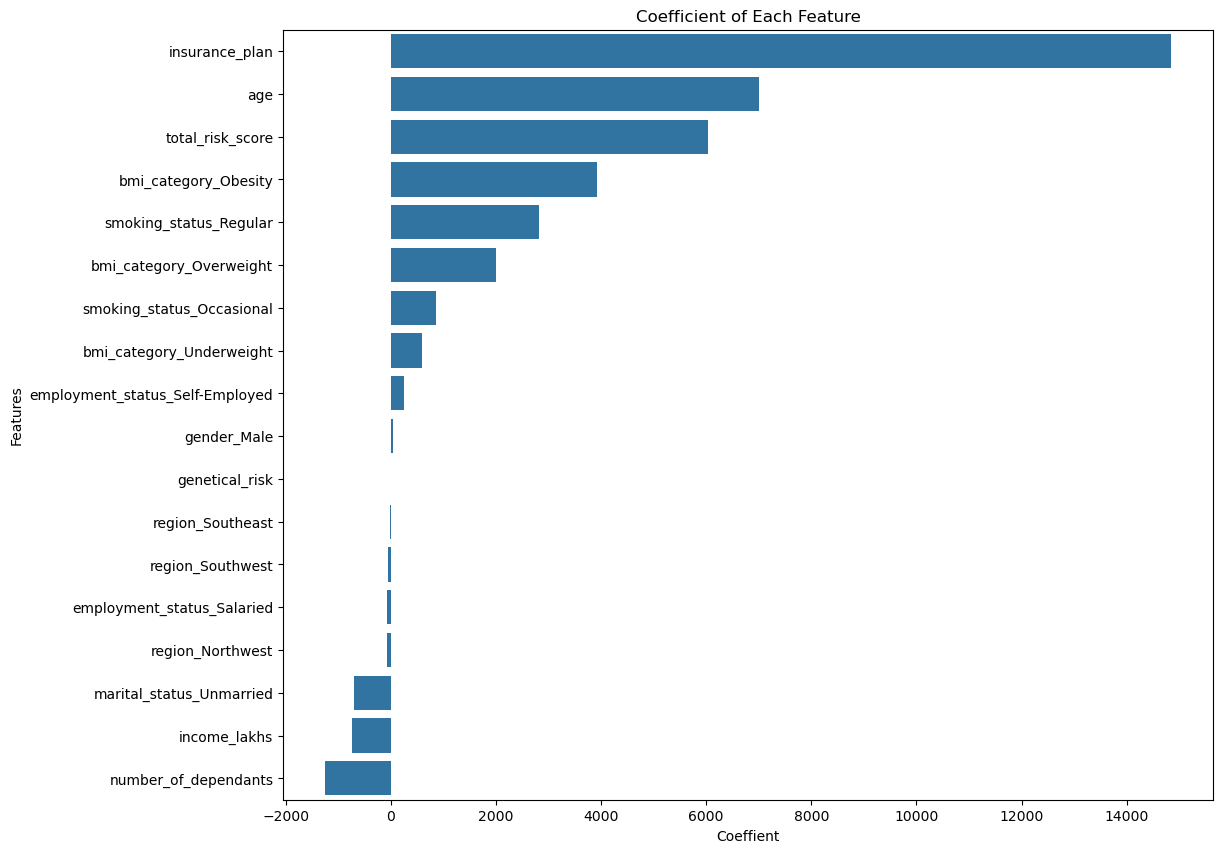

In [105]:
# Plotting the features and its coefficients

plt.figure(figsize=(12,10))
sns.barplot(data=feat_coef_df.sort_values(by=['coef'],ascending=False),x = 'coef',y = 'features' )
plt.title('Coefficient of Each Feature')
plt.xlabel('Coeffient')
plt.ylabel('Features')
plt.show()

#### Lasso Regression

In [106]:
# Initialize and train the Lasso Regression model
ls = Lasso()
ls.fit(X_train,y_train)

# Evaluate model performance
train_score = ls.score(X_train,y_train)
test_score = ls.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.953075755555294 , Test Score : 0.9546217761285843 


In [107]:
# Predict on test data
y_pred = ls.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 2183318.290405165 , RMSE : 1477.6055936565633


#### Ridge Regression

In [108]:
# Initialize and train the Ridge Regression model
rg = Ridge()
rg.fit(X_train,y_train)

# Evaluate model performance
train_score = rg.score(X_train,y_train)
test_score = rg.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9530813964457598 , Test Score : 0.9546123167812729 


In [109]:
# Predict on test data
y_pred = rg.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 2183773.415446172 , RMSE : 1477.7595932512745


**Observation**

Neither Lasso nor Ridge regression showed significant improvement over Linear Regression.

#### Random Forest Regressor

In [110]:
# Initialize and train the Random Forest Regression model
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

# Evaluate model performance
train_score = rfr.score(X_train,y_train)
test_score = rfr.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9996676401794461 , Test Score : 0.9975696814607082 


In [111]:
# Predict on test data
y_pred = rfr.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 116931.83350194864 , RMSE : 341.9529697223708


Based on the R² score, it can be seen that this model fits the data well. The XGBoost model will be tried next.

#### XGboost Regressor

In [112]:
# Initialize and train the XGboost model
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

# Evaluate model performance
train_score = xgb.score(X_train,y_train)
test_score = xgb.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9986407160758972 , Test Score : 0.9980074167251587 


In [113]:
# Predict on test data
y_pred = xgb.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 95870.859375 , RMSE : 309.63018798828125


**Model Performance Comparison: XGBoost vs. Random Forest**

Both XGBoost and Random Forest models are observed to perform well on the dataset. However, the following points are noted:

- A lower training score and a higher test score are yielded by the XGBoost model compared to Random Forest.
- This suggests that the XGBoost model generalizes better and is less prone to overfitting.
- To validate this observation, cross-validation will be used to evaluate both models more robustly using `cross_validate`.

### Cross Validation - RF vs XGboost

Cross-validation will be performed on both Random Forest and XGBoost models, with the run time also being recorded.  
The `cross_validate` function is used instead of `cross_val_score` to obtain both training and testing scores.

Stratified K-Fold will not be performed since this is a regression task; therefore, K-Fold cross-validation is considered sufficient.

In [114]:
# Set up 5-fold cross-validation

kf = KFold(n_splits = 5,shuffle=True,random_state=42)

In [115]:
# Perform cross-validation for Random Forest Regressor

start_time = time()
cv_rfr = cross_validate(rfr,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_rfr = end_time - start_time
print(f'Total Time Taken : {round(total_time_rfr,2)} seconds')

Total Time Taken : 32.38 seconds


In [116]:
# Display training scores
print("Training scores (R²):", cv_rfr['train_score'])

# Display test scores
print("Validation scores (R²):", cv_rfr['test_score'])

Training scores (R²): [0.9996709  0.99967333 0.99967341 0.99966754 0.99966894]
Validation scores (R²): [0.99772117 0.99765254 0.99776012 0.99775534 0.9976467 ]


In [117]:
# Perform cross-validation for XGboost Regressor

start_time = time()
cv_xgb = cross_validate(xgb,features,target,cv=kf,return_train_score=True,scoring='r2')
end_time = time()
total_time_xgb = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb,2)} seconds')

Total Time Taken : 0.49 seconds


In [118]:
# Display training scores
print("Training scores (R²):", cv_xgb['train_score'])

# Display test scores
print("Validation scores (R²):", cv_xgb['test_score'])

Training scores (R²): [0.99858898 0.99860317 0.99861193 0.99860734 0.99860102]
Validation scores (R²): [0.99807101 0.99800855 0.99797148 0.99803388 0.99799657]


In [119]:
cv_df = pd.DataFrame(
    {
        'model' : ['Random Forest','XGboost'],
        'execution_time (seconds)' : [total_time_rfr,total_time_xgb],
        'average_train_score' : [np.mean(cv_rfr['train_score']),np.mean(cv_xgb['train_score'])],
        'average_test_score' : [np.mean(cv_rfr['test_score']),np.mean(cv_xgb['test_score'])]
    }
)

cv_df

,model,execution_time (seconds),average_train_score,average_test_score
0,Random Forest,32.378422,0.999671,0.997707
1,XGboost,0.493885,0.998602,0.998016


**Cross-Validation Summary: XGBoost vs. Random Forest**

The cross-validation results confirm that XGBoost is consistently observed to generalize better than the Random Forest model:

- *Lower training scores* and *higher test scores* were achieved by XGBoost, indicating *better generalization* and *reduced overfitting*.
- In terms of performance, XGBoost was approximately ***83 times faster*** than Random Forest during cross-validation.

Given its superior predictive performance and computational efficiency, **XGBoost will be selected as the final model**.


### Hyperparameter Tuning

The model will be fine-tuned using `RandomizedSearchCV`, as it is computationally less expensive than `GridSearchCV`.

Hyperparameter combinations are randomly sampled, making this approach generally faster for large search spaces.

#### RandomizedSearchCV

In [120]:
xgb = XGBRegressor(booster= 'gbtree')

In [121]:
param_grid = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1,0.15,0.2],
    'max_depth' : [7,8,9],
    'gamma' : [1,2,3]
    
}

A total of 81 hyperparameter combinations are available. A smaller subset of combinations will be selected to reduce computational cost.

In [122]:
# Adjust based on resources

iter_to_perform = 10

In [123]:
# Initialize RandomizedSearchCV

rscv = RandomizedSearchCV(xgb,param_grid,cv=kf,n_iter=iter_to_perform,random_state=42)

In [124]:
# Executing RandomizedSearchCV and Timing the search

start_time = time()
rscv.fit(features,target)
end_time = time()
total_time_xgb_hyp = end_time - start_time
print(f'Total Time Taken : {round(total_time_xgb_hyp,2)} seconds')

Total Time Taken : 10.49 seconds


#### Best Model

In [125]:
# Displaying the results of RandomizedSearchCV execution

pd.DataFrame(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.141169,0.010019,0.006617,0.000893,100,8,0.10,2,"{'n_estimators': 100, 'max_depth': 8, 'learnin...",0.998101,0.997980,0.998020,0.998108,0.998022,0.998046,0.000050,3
1,0.106182,0.003126,0.005674,0.000086,100,7,0.10,1,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.998162,0.998084,0.998072,0.998146,0.998097,0.998112,0.000035,1
2,0.255504,0.005738,0.008596,0.000690,200,8,0.20,1,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.997885,0.997795,0.997829,0.997890,0.997813,0.997843,0.000038,9
3,0.251819,0.002560,0.008339,0.000285,200,8,0.10,2,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.998033,0.997918,0.997962,0.998046,0.997948,0.997981,0.000050,8
4,0.101066,0.002174,0.005643,0.000074,100,7,0.20,1,"{'n_estimators': 100, 'max_depth': 7, 'learnin...",0.998079,0.998033,0.998013,0.998064,0.998010,0.998040,0.000028,4
5,0.190834,0.003463,0.007331,0.000039,200,7,0.10,2,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.998117,0.998040,0.998034,0.998092,0.998050,0.998067,0.000032,2
6,0.190057,0.002176,0.007524,0.000157,200,7,0.15,1,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.998059,0.997986,0.997981,0.998033,0.998001,0.998012,0.000030,5
7,0.357251,0.005664,0.009133,0.000235,200,9,0.15,3,"{'n_estimators': 200, 'max_depth': 9, 'learnin...",0.997817,0.997697,0.997813,0.997871,0.997761,0.997792,0.000059,10
8,0.252184,0.003799,0.008045,0.000046,200,8,0.10,1,"{'n_estimators': 200, 'max_depth': 8, 'learnin...",0.998043,0.997918,0.997962,0.998046,0.997949,0.997983,0.000052,7
9,0.134802,0.002207,0.006074,0.000139,100,8,0.15,1,"{'n_estimators': 100, 'max_depth': 8, 'learnin...",0.998067,0.997936,0.997987,0.998057,0.997989,0.998007,0.000049,6


In [126]:
# Best score we get from the Tuning

rscv.best_score_

np.float64(0.9981124043464661)

In [127]:
# Parameters that gave the best score

rscv.best_params_

{'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1}

In [128]:
# Model that resulted the best score

best_model = rscv.best_estimator_
best_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Performance of the 'Best Model'

The best model’s performance was evaluated on the test set to assess its real-world effectiveness.

#### Scores

In [129]:
# Evaluate Best model's performance
train_score = best_model.score(X_train,y_train)
test_score = best_model.score(X_test,y_test)

# Print the R² scores
print(f'Train Score : {train_score} , Test Score : {test_score} ')

Train Score : 0.9983927607536316 , Test Score : 0.9984047412872314 


In [130]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test,y_pred)
rmse = root_mean_squared_error(y_test,y_pred)

# Print performance metrics of the best model
print(f'MSE : {mse} , RMSE : {rmse}')

MSE : 76752.8828125 , RMSE : 277.0431213378906


#### Features and their Importance

The contribution of each feature to the model's predictions was analyzed.

In [131]:
# Retrieve feature names used during model training (available after fitting)

best_model.feature_names_in_

array(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'total_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='<U31')

In [132]:
# Feature importance scores from the fitted model

best_model.feature_importances_

array([1.06007792e-02, 9.78365460e-06, 1.15282610e-05, 9.45190191e-01,
       0.00000000e+00, 1.07067609e-02, 1.02383092e-05, 1.07027372e-05,
       1.21634885e-05, 9.58970668e-06, 1.15327502e-05, 1.18038226e-02,
       5.99558605e-03, 4.32216213e-04, 1.30533322e-03, 1.38664301e-02,
       1.19587467e-05, 1.14041950e-05], dtype=float32)

In [133]:
# Create a DataFrame of features and their corresponding importance scores
feat_coef_df = pd.DataFrame(
    {
        'features' : best_model.feature_names_in_,
        'importance' : best_model.feature_importances_
    }
)

# Sort the features by importance in descending order
feat_coef_df = feat_coef_df.sort_values(by=['importance'],ascending=False)
feat_coef_df

,features,importance
3,insurance_plan,0.945190
15,smoking_status_Regular,0.013866
11,bmi_category_Obesity,0.011804
5,total_risk_score,0.010707
0,age,0.010601
12,bmi_category_Overweight,0.005996
14,smoking_status_Occasional,0.001305
13,bmi_category_Underweight,0.000432
8,region_Southeast,0.000012
16,employment_status_Salaried,0.000012


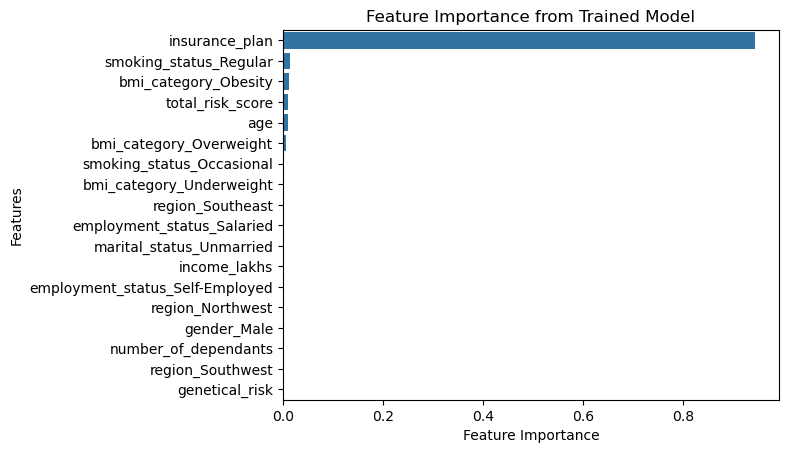

In [134]:
# Plot feature importances using a horizontal bar chart
sns.barplot(data = feat_coef_df, x='importance',y='features')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Trained Model")
plt.show()

## Error Anlysis

The prediction errors (residuals) will be analyzed to evaluate the model’s performance.

**Objective:**  
Ensure that 95% of incorrect predictions deviate by ≤10% from the actual values.

**Approach:**  
- Residuals will be calculated as: residual = actual − predicted  
- Percentage error relative to actual values will be computed.  
- The proportion of errors falling within the 10% threshold will be checked.  
- Any consistent error patterns across customer segments will be identified.

In [135]:
# Predict on test data

y_pred = best_model.predict(X_test)

In [136]:
# Check the shape of predictions and actual test labels to ensure alignment

print("Predicted labels shape:", y_pred.shape)
print("Actual labels shape:", y_test.shape)

Predicted labels shape: (8947,)
Actual labels shape: (8947,)


### Residuals 

The difference between the predicted values and the actual values will be determined.

In [137]:
# Calculate residuals (difference between predicted and actual values)
residuals = y_pred - y_test

# Display the residuals
residuals

5477     205.810547
579       69.162109
279     -405.337891
15395   -275.164062
24210    282.304688
            ...    
12266   -226.117188
2109     314.201172
23454    -74.566406
29602   -188.393555
11040    156.613281
Name: annual_premium_amount, Length: 8947, dtype: float64

In [138]:
# Calculate the residual percentage
# What it shows? - How much the predicted value is deviated from the actual value
# 2.68 -> Predicted Value is 2.68% higher than the actual value

residuals_pct = ((y_pred - y_test) / y_test)*100
residuals_pct

5477     0.667393
579      0.262914
279     -2.254006
15395   -1.422404
24210    0.847329
           ...   
12266   -0.669778
2109     1.271555
23454   -0.235158
29602   -1.746487
11040    0.669030
Name: annual_premium_amount, Length: 8947, dtype: float64

Everything will be put into a dataframe for better understanding.

In [139]:
# Create a dictionary to store actual, predicted, residuals, and residual percentages
residual_dict = {
    'actual' : y_test,
    'predicted' : y_pred,
    'residual' : residuals,
    'residual_pct' : residuals_pct
}

# Convert the dictionary into a DataFrame for easier analysis
residual_df = pd.DataFrame(residual_dict)

# Display the DataFrame
residual_df

,actual,predicted,residual,residual_pct
5477,30838,31043.810547,205.810547,0.667393
579,26306,26375.162109,69.162109,0.262914
279,17983,17577.662109,-405.337891,-2.254006
15395,19345,19069.835938,-275.164062,-1.422404
24210,33317,33599.304688,282.304688,0.847329
...,...,...,...,...
12266,33760,33533.882812,-226.117188,-0.669778
2109,24710,25024.201172,314.201172,1.271555
23454,31709,31634.433594,-74.566406,-0.235158
29602,10787,10598.606445,-188.393555,-1.746487


In [140]:
# Sort the residual_df by residual_pct in descending order to see the largest errors first

residual_df.sort_values(by=['residual_pct'],ascending=False)

,actual,predicted,residual,residual_pct
8248,6548,7131.916992,583.916992,8.917486
6119,6538,7069.366211,531.366211,8.127351
17759,6569,7075.352051,506.352051,7.708206
8194,6635,7105.947266,470.947266,7.097924
15365,6625,7092.777832,467.777832,7.060797
...,...,...,...,...
22750,9616,9077.530273,-538.469727,-5.599727
19398,9645,9088.835938,-556.164062,-5.766346
7004,8047,7563.033691,-483.966309,-6.014245
28651,7579,7122.812500,-456.187500,-6.019099


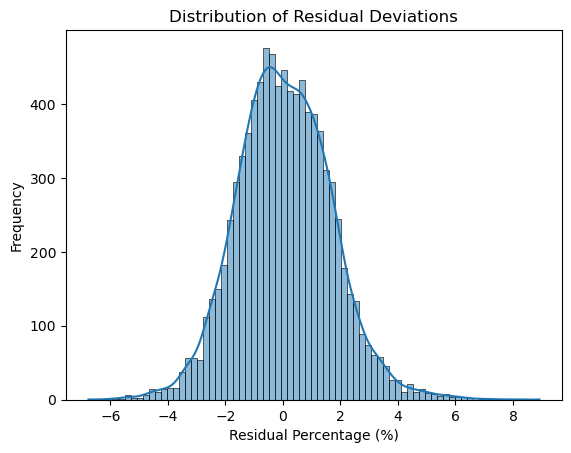

In [141]:
# Plot the distribution of residual percentages with a Kernel Density Estimate (KDE) overlay
sns.histplot(data = residual_df, x = 'residual_pct',kde=True )
plt.title('Distribution of Residual Deviations')
plt.xlabel('Residual Percentage (%)')
plt.ylabel('Frequency')
plt.show()

As observed above, even at the maximum, the predicted values are deviated from the actual values by only 9%.

### Analysing Extreme Residuals

As stated in the Statement of Work (SOW):

- The goal is to ensure that 95% of incorrect predictions deviate by no more than 10% from the actual values.

This implies that even when predictions are incorrect, **95%** of them should exhibit **less than 10% deviation** - either above or below the actual values.

In other words, only **5%** of incorrect predictions are permitted to deviate by **more than 10%** from the actual values.

Based on this requirement, the deviation threshold has been set at **10%**.

In [142]:
# Acceptable percentage deviation allowed between actual and expected values

deviation_pct = 10

In [143]:
# Filter rows where the absolute residual percentage exceeds the deviation_pct (10%)
residual_df[abs(residual_df['residual_pct']) > deviation_pct]

,actual,predicted,residual,residual_pct


### Final Verdict

The resulting DataFrame is empty, indicating that **none of the predictions** deviate from the actual values by more than the allowed 10%.  
This confirms that the model satisfies the deviation constraint specified in the SOW.

Therefore, it can be concluded that the model performed well on the subset of data where **age > 25**.


## Export Artifacts

In [144]:
model_artifacts = {
    'model_data': {
                    'trained_model' : best_model,
                    'feature_names' : best_model.feature_names_in_
                    },
    'scaler_data' : {
                    'scaler_object' : mms,
                    'scaled_columns' : cols_to_scale
                    } 
    }

In [145]:
project_root

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator'

In [146]:
# Define artifacts path

artifact_folder = 'artifacts'
artifact_name = 'insurance_premium_pipeline_rest'
artifact_extension = 'joblib'

artifact_save_path = fr'{project_root}\{artifact_folder}\{artifact_name}.{artifact_extension}'
artifact_save_path

'C:\\Users\\91948\\Downloads\\BKs\\Projects\\personalized_health_insurance_premium_estimator\\artifacts\\insurance_premium_pipeline_rest.joblib'

In [147]:
try:
    joblib.dump(model_artifacts, artifact_save_path)
    print(f"Saved artifacts successfully at {artifact_save_path}")
except Exception as e:
    print(f"Error saving artifacts: {e}")

Saved artifacts successfully at C:\Users\91948\Downloads\BKs\Projects\personalized_health_insurance_premium_estimator\artifacts\insurance_premium_pipeline_rest.joblib
